In [1]:
from Utils.DataPreprocessing import split_data, data_cleaning, glove_embedding
import torch
from torch import nn
from torch.utils.data import IterableDataset, Dataset, DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import GloVe, vocab, build_vocab_from_iterator
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import os
import transformers

In [2]:
random_seed = 0
training_set_size = 0.8
GLOVE_TXT_PATH = '../../GloVe Embeddings/glove.840B.300d.txt'
MAX_TOKEN_NBS = 1500 # max number of tokens in each review

In [3]:
imdb_data = pd.read_csv('Data/IMDB Dataset.csv')
imdb_data = data_cleaning(imdb_data)
train_set, test_set = split_data(imdb_data, training_set_size, random_seed)

/mnt/i/Projects/evaluation-deeplearning-NLP/Utils/DataPreprocessing.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset['review'] = dataset['review'].str.replace('<.*?>', '')


In [4]:
if os.path.isdir("./.vector_cache"):
    glove_vectors = GloVe(name = '840B', cache = './.vector_cache')
else:
    glove_vectors = GloVe('840B')

In [5]:
pad_token = "<pad>"
glove_vocab = vocab(glove_vectors.stoi)
glove_vocab.insert_token("<pad>", 0)
# This is necessary otherwise it will throw runtime error if OOV token is queried
glove_vocab.set_default_index(0)
pretrained_embeddings = glove_vectors.vectors
pretrained_embeddings = torch.cat((torch.zeros(1,pretrained_embeddings.shape[1]),pretrained_embeddings))

In [6]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-cased')


class BertDataSet(Dataset):
    def __init__(self, dataframe):
        self.comments = dataframe['review'].values
        self.labels = dataframe['sentiment'].to_numpy()

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, idx):
        comment = self.comments[idx]
        tokenized_comment = tokenizer.encode_plus(comment,
                                                    add_special_tokens=True,
                                                    max_length = 512,
                                                    padding='max_length',
                                                    truncation = True,
                                                    return_attention_mask = True)
        ids = torch.tensor(tokenized_comment['input_ids'], dtype=torch.long)
        mask = torch.tensor(tokenized_comment['attention_mask'], dtype=torch.long)

        labels = self.labels[idx]
        labels = torch.tensor(labels, dtype=torch.float)
        return {'ids': ids, 'mask': mask, 'labels': labels}

In [7]:
train_dataset = BertDataSet(train_set)
test_dataset = BertDataSet(test_set)

In [8]:
train_batch = 16
test_batch = 16
data_loader_train = DataLoader(train_dataset, batch_size=train_batch, shuffle=True, pin_memory = True)
data_loader_test = DataLoader(test_dataset, batch_size=test_batch, shuffle=False, pin_memory = True)

In [9]:
model = transformers.BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels = 1)
gpus = torch.cuda.device_count()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if gpus > 1:
    print("Let's use", gpus, "GPUs!")
    # model = torch.nn.DataParallel(model)    # multi-gpu
model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [10]:
loss_fn = torch.nn.BCEWithLogitsLoss()
loss_fn.to(device)
epochs = 5
LR = 2e-5 #Learning rate
optimizer = torch.optim.AdamW(model.parameters(), LR, weight_decay = 1e-2)
torch.backends.cudnn.benchmark = True

In [11]:
for td in test_dataset:
    print(td['ids'].shape, td['mask'].shape, td['labels'])
    break

torch.Size([512]) torch.Size([512]) tensor(1.)


Epoch: 0 Train_Loss: 0.2360340190768242 Train_Accuracy: 0.8965
Epoch: 0 Test_Loss: 0.17206519975885748 Test_Accuracy: 0.9333


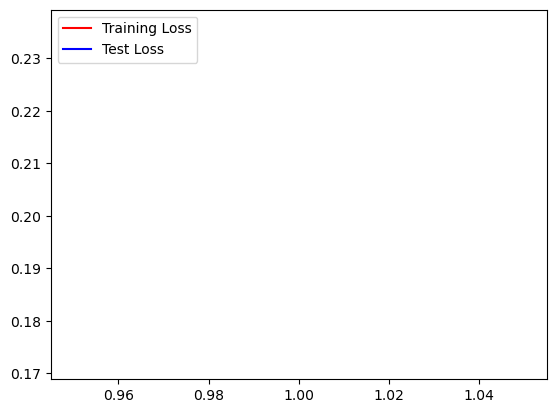

Epoch: 1 Train_Loss: 0.11775058256350458 Train_Accuracy: 0.95745
Epoch: 1 Test_Loss: 0.18195318910479547 Test_Accuracy: 0.9396


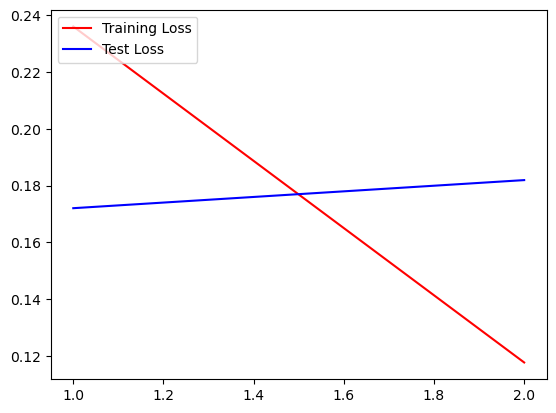

Epoch: 2 Train_Loss: 0.06620961410328746 Train_Accuracy: 0.97715
Epoch: 2 Test_Loss: 0.22549566244147717 Test_Accuracy: 0.9361


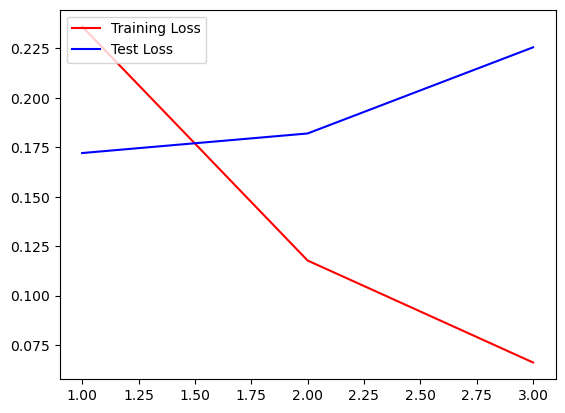

Epoch: 3 Train_Loss: 0.04513042740609963 Train_Accuracy: 0.984225
Epoch: 3 Test_Loss: 0.22761594249429182 Test_Accuracy: 0.9368


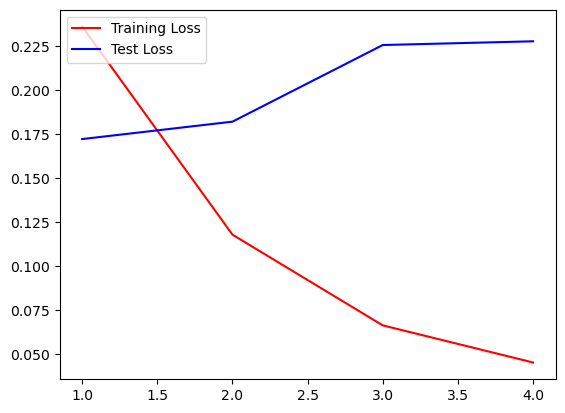

Epoch: 4 Train_Loss: 0.03174313257269096 Train_Accuracy: 0.9894
Epoch: 4 Test_Loss: 0.21447799629308284 Test_Accuracy: 0.941


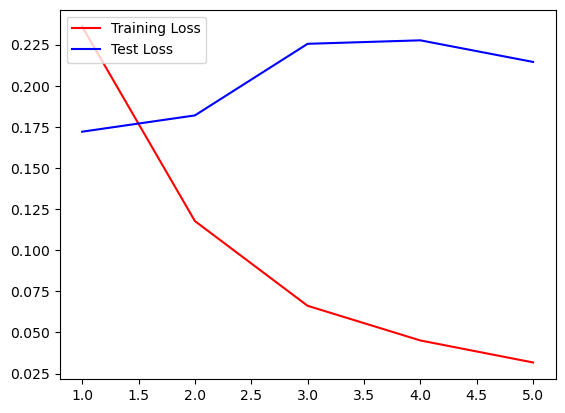

Epoch: 5 Train_Loss: 0.025955450866516912 Train_Accuracy: 0.991775
Epoch: 5 Test_Loss: 0.29121905555822886 Test_Accuracy: 0.9359


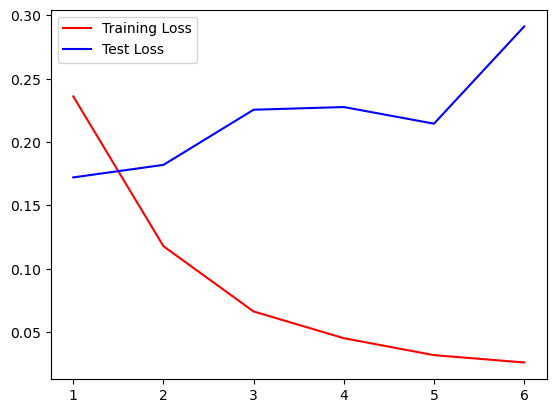

KeyboardInterrupt: 

In [12]:
from matplotlib import pyplot as plt

epochs = 250

training_losses = [ None for i in range(epochs)]
test_losses = [ None for i in range(epochs)]
epoch_count = [i for i in range(1, epochs+1)]
recalls = [ None for i in range(epochs)]
precisions = [ None for i in range(epochs)]
accuracys = [ None for i in range(epochs)]
for e in range(epochs):
    model.train()
    epoch_loss = 0

    losses = []
    train_predictions_store = []
    train_labels_store = []
    for batch_id, batch in enumerate(data_loader_train):

        ids = batch['ids'].to(device)
        mask = batch['mask'].to(device)
        optimizer.zero_grad()
        outputs = model(ids, mask)
        outputs = outputs['logits'].squeeze(-1).to(torch.float32)
        outputs = torch.reshape(outputs, (-1,))
        probs = torch.sigmoid(outputs)
        preds = torch.where(outputs > 0.5, 1, 0)
        labels = batch['labels'].to(device, non_blocking=True)

        loss = loss_fn(outputs, labels)

        labels = labels.to(torch.device("cpu")).numpy()
        preds = preds.to(torch.device("cpu")).numpy()
        for i in range(len(preds)):
            train_predictions_store.append(preds[i])
            train_labels_store.append(labels[i])

        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    epoch_loss = np.mean(losses)

    training_losses[e] = epoch_loss
    train_accuracy = accuracy_score(train_labels_store, train_predictions_store)

    #  rp = classification_report(train_labels_store, train_predictions_store, target_names=['0','1'])
    #  print(rp)

    # Evaluate on test set
    with torch.no_grad():
        model.eval()
        test_loss = []
        test_correct_predictions = 0
        test_predictions_store = []
        test_labels_store = []

        for batch_id, batch in enumerate(data_loader_test):
            ids = batch['ids'].to(device)
            mask = batch['mask'].to(device)
            outputs = model(ids, mask)
            outputs = outputs['logits'].squeeze(-1).to(torch.float32)
            outputs = torch.reshape(outputs, (-1,))

            probs = torch.sigmoid(outputs)
            preds = torch.where(outputs > 0.5, 1, 0)
            labels = batch['labels'].to(device, non_blocking=True)
            loss = loss_fn(outputs, labels)

            test_correct_predictions += torch.sum(preds == labels)
            test_loss.append(loss.item())

            labels = labels.to(torch.device("cpu")).numpy()
            preds = preds.to(torch.device("cpu")).numpy()
            for i in range(len(preds)):
                test_predictions_store.append(preds[i])
                test_labels_store.append(labels[i])

        test_loss = np.mean(test_loss)
        test_accuracy = accuracy_score(test_labels_store, test_predictions_store)
        test_losses[e] = test_loss

        #rp = classification_report(test_labels_store, test_predictions_store, target_names=['0','1'])
        #print(rp)
        print('Epoch: {} Train_Loss: {} Train_Accuracy: {}'.format(e, epoch_loss, train_accuracy))
        print('Epoch: {} Test_Loss: {} Test_Accuracy: {}'.format(e, test_loss, test_accuracy))

        plt.plot(epoch_count, training_losses, 'r', label='Training Loss')
        plt.plot(epoch_count, test_losses, 'b', label='Test Loss')
        plt.legend(loc="upper left")

        plt.show()